In [1]:
import imp
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, GlobalAveragePooling2D, InputLayer, LeakyReLU
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16, resnet
from keras.layers import *
from keras.models import Model,Sequential
from keras import optimizers
from keras import regularizers
import tensorflow as tf
from tensorflow import keras
import os
import shutil
import glob 
import csv
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split

/tmp/ipykernel_28/1771233803.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/

In [2]:
def gen_label(directory):
    label = []
    for dir in os.listdir(directory):
        for files in os.listdir(os.path.join(directory, dir)):
            if (dir == 'no'):
                label.append(str(0))
            elif (dir == 'yes'):
                label.append(str(1))
    return label

def get_path(directory):
    path = []
    for dirs in os.listdir(directory):
        for files in os.listdir(os.path.join(directory, dirs)):
            path.append(dirs + "/" +files)
    return path

In [3]:
train_y = gen_label('brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset')
train_x = get_path('brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset')

In [4]:
len(train_x)

253

In [5]:
len(train_y)

253

In [6]:
df = pd.DataFrame({'filename': train_x,
                  'category': train_y})
print(df)

         filename category
0    no/34 no.jpg        0
1      no/N20.JPG        0
2       no/N1.JPG        0
3    no/49 no.jpg        0
4      no/N15.jpg        0
..            ...      ...
248  yes/Y113.JPG        1
249  yes/Y101.jpg        1
250   yes/Y89.JPG        1
251   yes/Y44.JPG        1
252   yes/Y92.png        1

[253 rows x 2 columns]


In [7]:
train_df, valid_df = train_test_split(df, test_size=0.2)
print(train_df.shape)
print(valid_df.shape)

(202, 2)
(51, 2)


In [8]:
image_data = ImageDataGenerator(rescale=1./255,
                                validation_split = 0.2,
                                zoom_range=(0.99,0.99))

def preprocessingTrain(path):
    image = image_data.flow_from_directory(directory=path, 
                                           target_size=(224,224), 
                                           batch_size=8, 
                                           seed=123,
                                           subset='training',)
    return image

In [9]:
def preprocessingVal(path):
    
    image_data = ImageDataGenerator(rescale=1/255,
                                   validation_split = 0.2,)
    image = image_data.flow_from_directory(directory=path,
                                           seed=123,
                                           target_size = (224,224),
                                           batch_size = 8,
                                           subset='validation'
                                           )
    return image

In [10]:
def preprocessingTest(path):
    
    image_data = ImageDataGenerator(rescale=1/255)
    image = image_data.flow_from_directory(directory=path,
                                           seed=123,
                                           target_size = (224,224),
                                           batch_size = 8,
                                           )
    
    return image

In [11]:
path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
train_data = preprocessingTrain(path)

Found 203 images belonging to 2 classes.


In [12]:

path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
val_data= preprocessingVal(path)

Found 50 images belonging to 2 classes.


In [13]:
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

model = keras.Sequential()

model.add(InputLayer(input_shape=(224,224,3)))

model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())


model.add(Flatten()) #


# model.add(Dense(2048, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(rate=0.3))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
# model.add(Dense(512, activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(rate=0.3))
model.add(Dense(2, activation="sigmoid"))


model.compile(optimizer=Adam(0.001),loss = BinaryCrossentropy(),metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 1024)              2

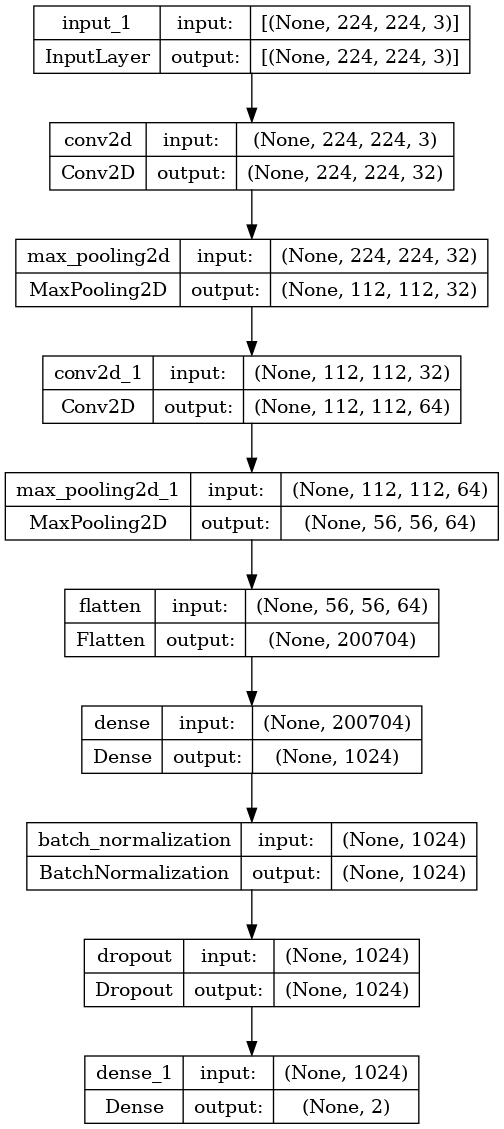

In [14]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

In [15]:
# Early stopping and model checkpoint
from keras import utils, callbacks

earlystopping = callbacks.EarlyStopping(monitor="val_loss", 
                                        mode="min", 
                                        patience=5, 
                                        restore_best_weights = True)

In [16]:
# model = Sequential()
history = model.fit_generator(train_data,
                              verbose=1,
                              callbacks = [earlystopping],
                              epochs=30,
                              validation_data=(val_data))

/tmp/ipykernel_28/3204587608.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,


Epoch 1/30
26/26 [==============================] - 15s 231ms/step - loss: 1.0760 - accuracy: 0.7291 - val_loss: 1.4935 - val_accuracy: 0.6600
Epoch 2/30
26/26 [==============================] - 4s 140ms/step - loss: 0.4358 - accuracy: 0.8079 - val_loss: 2.9659 - val_accuracy: 0.7200
Epoch 3/30
26/26 [==============================] - 4s 148ms/step - loss: 0.2735 - accuracy: 0.9015 - val_loss: 0.8448 - val_accuracy: 0.6800
Epoch 4/30
26/26 [==============================] - 3s 112ms/step - loss: 0.1635 - accuracy: 0.9557 - val_loss: 1.2088 - val_accuracy: 0.6800
Epoch 5/30
26/26 [==============================] - 4s 149ms/step - loss: 0.1557 - accuracy: 0.9360 - val_loss: 0.6243 - val_accuracy: 0.7400
Epoch 6/30
26/26 [==============================] - 3s 113ms/step - loss: 0.1529 - accuracy: 0.9606 - val_loss: 1.4056 - val_accuracy: 0.8000
Epoch 7/30
26/26 [==============================] - 3s 111ms/step - loss: 0.1115 - accuracy: 0.9655 - val_loss: 1.2147 - val_accuracy: 0.6800
Epoch

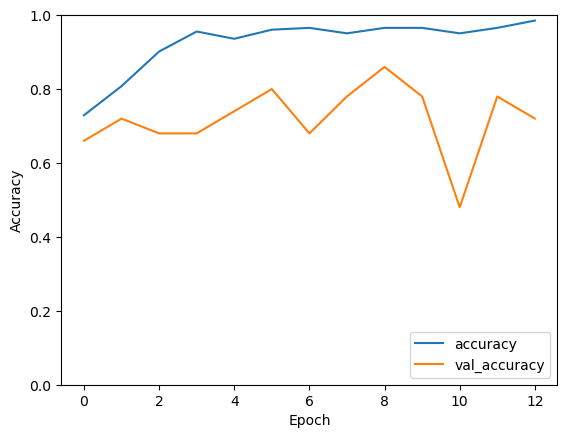

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

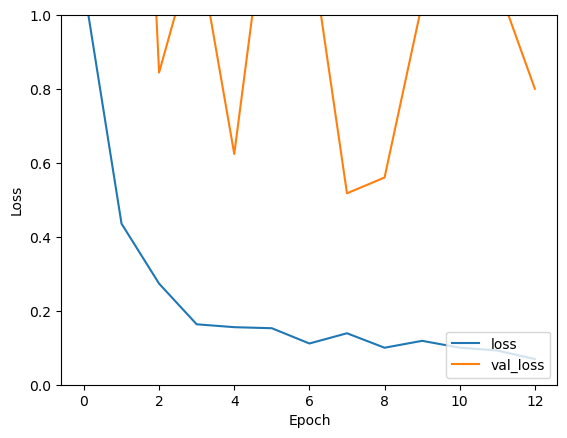

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [19]:
model.pop()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 1024)              2

In [21]:
train_x

['no/34 no.jpg',
 'no/N20.JPG',
 'no/N1.JPG',
 'no/49 no.jpg',
 'no/N15.jpg',
 'no/No18.jpg',
 'no/31 no.jpg',
 'no/no 6.jpg',
 'no/3 no.jpg',
 'no/no 5.jpeg',
 'no/no 1.jpg',
 'no/26 no.jpg',
 'no/N26.JPG',
 'no/N5.jpg',
 'no/6 no.jpg',
 'no/No21.jpg',
 'no/17 no.jpg',
 'no/No22.jpg',
 'no/29 no.jpg',
 'no/46 no.jpg',
 'no/32 no.jpg',
 'no/42 no.jpg',
 'no/no 90.jpg',
 'no/no 94.jpg',
 'no/No19.jpg',
 'no/47 no.jpg',
 'no/N22.JPG',
 'no/No12.jpg',
 'no/15 no.jpg',
 'no/20 no.jpg',
 'no/No13.jpg',
 'no/11 no.jpg',
 'no/N11.jpg',
 'no/No17.jpg',
 'no/no 98.jpg',
 'no/18 no.jpg',
 'no/N19.JPG',
 'no/25 no.jpg',
 'no/24 no.jpg',
 'no/no 91.jpeg',
 'no/45 no.jpg',
 'no/22 no.jpg',
 'no/No16.jpg',
 'no/44no.jpg',
 'no/4 no.jpg',
 'no/36 no.jpg',
 'no/8 no.jpg',
 'no/48 no.jpeg',
 'no/No20.jpg',
 'no/no 2.jpg',
 'no/no 10.jpg',
 'no/7 no.jpg',
 'no/10 no.jpg',
 'no/N17.jpg',
 'no/14 no.jpg',
 'no/no 8.jpg',
 'no/38 no.jpg',
 'no/40 no.jpg',
 'no/no 9.png',
 'no/N3.jpg',
 'no/no 89.jpg',
 'no

In [22]:
feature_list = []
for path in train_df['filename'].to_numpy():
    full_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'+ path
    x = load_img(full_path,target_size=(224,224))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(img_array)
    feature_list.append(features)
    
# feat_lst = np.reshape(feature_list,(-1,7*7*512))

1/1 [==============================] - 0s 19ms/step


In [23]:
feat_lst = np.reshape(feature_list,(-1,1024))

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# features = tarnsfer_model.predict(test_data)
# y  = test_label.astype('int')
y = train_df['category'].to_numpy()
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(feat_lst,
                                                                            y,
                                                                            test_size = 0.20,
                                                                            random_state = 2020)

In [25]:
import csv

# Assuming `features` is a numpy array
import numpy as np

# Define the image names
img_names = [y[i] for i in range(feat_lst.shape[0])]

# Write the features to a CSV file with column names and image names
with open('features.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image Label'] + list(range(1, feat_lst.shape[1]+1)))
    for i, row in enumerate(feat_lst):
        writer.writerow([img_names[i]] + list(row))

# Read the features from the CSV file
with open('features.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader) # Skip the first row (headers)
    img_names = [row[0] for row in reader] # Extract the image names
    feat_lst = np.array([row[1:] for row in reader]).astype(float) # Extract the features

In [26]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=4020)

#train classifier
rf_classifier.fit(train_features, train_labels)

# Make predictions on the test data
test_predictions = rf_classifier.predict(test_features)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Test accuracy: ", test_accuracy)

Test accuracy:  0.8780487804878049


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions, pos_label='0')
recall = recall_score(test_labels, test_predictions, pos_label='0')
f1 = f1_score(test_labels, test_predictions, pos_label='0')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.8421052631578947
Recall:  0.8888888888888888
F1-score:  0.8648648648648649


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions, pos_label='1')
recall = recall_score(test_labels, test_predictions, pos_label='1')
f1 = f1_score(test_labels, test_predictions, pos_label='1')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9090909090909091
Recall:  0.8695652173913043
F1-score:  0.888888888888889


In [29]:

#Fitting K-NN classifier to the training set  
from sklearn.neighbors import KNeighborsClassifier  
knnClassifier= KNeighborsClassifier(n_neighbors=2, metric='minkowski', p=2)  
knnClassifier.fit(train_features, train_labels)  

# Make predictions on the test data
test_predictions_knn = knnClassifier.predict(test_features)

# Calculate accuracy on the test data
test_accuracy_knn = accuracy_score(test_labels, test_predictions_knn)

print("Test accuracy: ", test_accuracy_knn)

Test accuracy:  0.8536585365853658


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_knn, pos_label='0')
recall = recall_score(test_labels, test_predictions_knn, pos_label='0')
f1 = f1_score(test_labels, test_predictions_knn, pos_label='0')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.8
Recall:  0.8888888888888888
F1-score:  0.8421052631578948


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_knn, pos_label='1')
recall = recall_score(test_labels, test_predictions_knn, pos_label='1')
f1 = f1_score(test_labels, test_predictions_knn, pos_label='1')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9047619047619048
Recall:  0.8260869565217391
F1-score:  0.8636363636363636


In [32]:
from sklearn.ensemble import AdaBoostClassifier
ab_classifier = AdaBoostClassifier(n_estimators=10, random_state=2020)
ab_classifier.fit(train_features, train_labels)
test_predictions_ab = ab_classifier.predict(test_features)
test_accuracy_ab = accuracy_score(test_labels, test_predictions_ab)

print("Test accuracy: ", test_accuracy_ab)

Test accuracy:  0.8536585365853658


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_ab, pos_label='0')
recall = recall_score(test_labels, test_predictions_ab, pos_label='0')
f1 = f1_score(test_labels, test_predictions_ab, pos_label='0')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.8
Recall:  0.8888888888888888
F1-score:  0.8421052631578948


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision
precision = precision_score(test_labels, test_predictions_ab, pos_label='1')
recall = recall_score(test_labels, test_predictions_ab, pos_label='1')
f1 = f1_score(test_labels, test_predictions_ab, pos_label='1')


print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

Precision:  0.9047619047619048
Recall:  0.8260869565217391
F1-score:  0.8636363636363636


In [35]:
def get_path(directory):
    path = []
    for dirs in os.listdir(directory):
        for files in os.listdir(os.path.join(directory, dirs)):
            path.append(dirs + "/" +files)
    return path

In [36]:
test_x = get_path('/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset')

In [37]:
# define function for evaluating model performance on test images
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img

testdf = pd.DataFrame({'filename': test_x})
test_sample = testdf.sample(n = 20, random_state=2020)

def test_img(model,name):
    result_lst = []
    for path in test_sample['filename'].to_numpy():
        full_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'+path
        x = load_img(full_path, target_size=(224,224))
        img_array = img_to_array(x)
        img_array = np.expand_dims(img_array, axis=0)
        if name == 'random_forest':
            features = model.predict(img_array)
            result = rf_classifier.predict(features)
        elif name == 'knn':
            features = model.predict(img_array)
            result = knnClassifier.predict(features)
        elif name == 'adaboost':
            features = model.predict(img_array)
            result = ab_classifier.predict(features)
        result = 'Healthy' if float(result) > 0.5 else 'Brain Tumor'
        
        result_lst.append(result)
    return result_lst

In [38]:
rf_result = test_img(model,'random_forest')
ada_result = test_img(model,'adaboost')
knn_result = test_img(model,'knn')

1/1 [==============================] - 0s 18ms/step


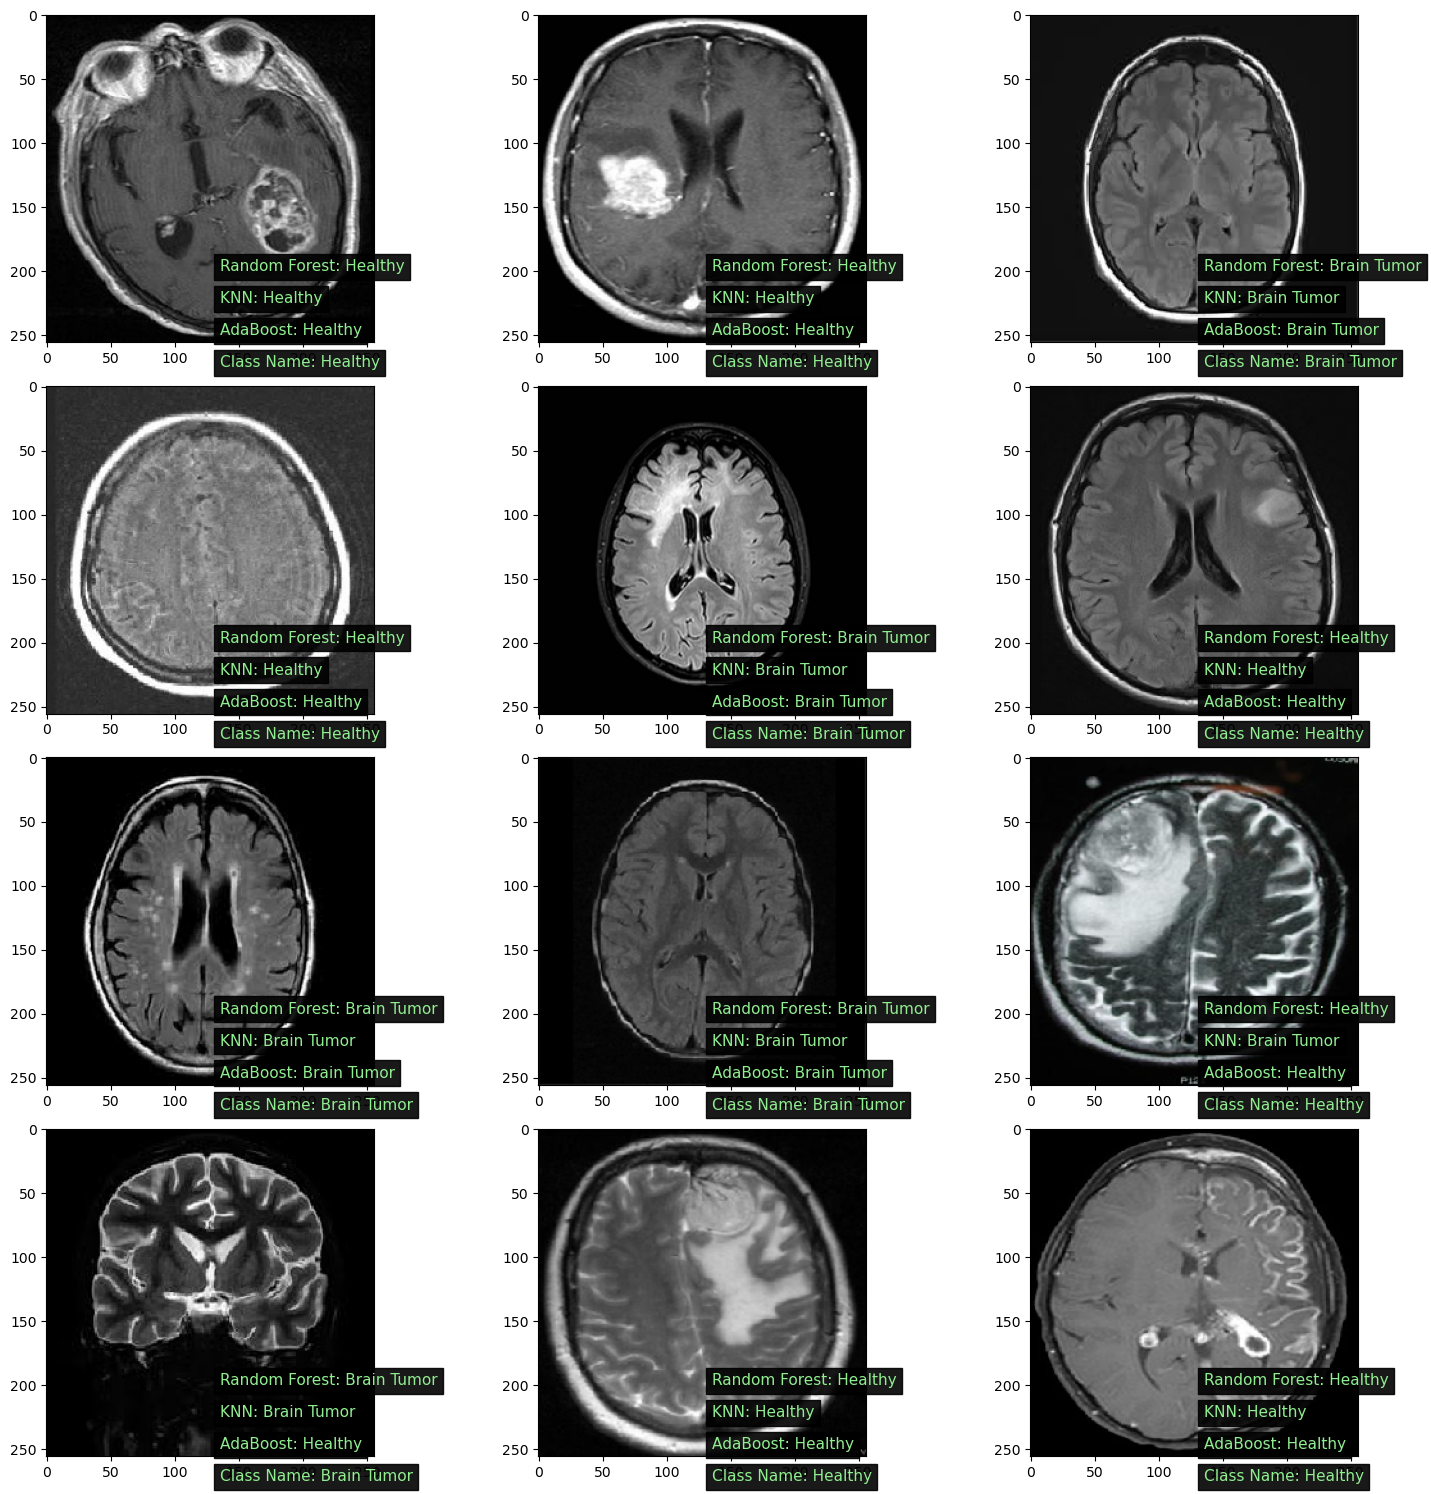

In [39]:
# plotting images with prediction
pred_results  = list(zip(rf_result,knn_result, ada_result))
test_array = test_sample['filename'].to_numpy()

plt.figure(figsize=(15, 15))
for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    rf, knn, ab= pred_results[i]
    img = test_array[i]
    path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/' + img
    name = img.split('/')[0]
    if(name == 'no'):
        name = 'Brain Tumor'
    if(name == 'yes'):
        name = 'Healthy'
    image = load_img(path, target_size=(256,256))
    # plt.text(135, 200, 'Custom CNN: {}'.format(cust), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 200, 'Random Forest: {}'.format(rf), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 225, 'KNN: {}'.format(knn), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 250, 'AdaBoost: {}'.format(ab), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(135, 275, 'Class Name: {}'.format(name), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    
    plt.imshow(image)

plt.tight_layout()
plt.show()